# Machine Learning (ML) 102 Workshop
* Author: Ryan Urbanowicz, PhD
*  Affiliation: University of Pennsylvania - Department of Biostatistics, Epidemiology, and Informatics & Institute for Biomedical Informatics (IBI) in collaboration with the Leonard Davis Institute (LDI)
* Date: 5/1/19

***
## Introduction
This notebook presents an example of a machine learning analysis pipeline from start to finish. It was written to be paired with the ML 102 Workshop presented in collaboration with IBI and LDI. Please note that this notebook is meant to present an accessible example, but does not necessarily include the optimal strategies to analyze the target dataset examined herein. Identifying the the optimal analysis pipeling steps/components is one of the fundamental challenges of data science.  This is almost never known ahead of time when seeking to tackle a new dataset/anlaysis. The pipeline presented below could be reproduced using different software or coding languages.  We have opted to utilize Python and the Jupyter notebook framework here due to is accessibility, flexibility, and prevalence in the ML community. 

For the purposes of this workshop this notebook is primarily meant to be viewed as an html link (pre-run) as a reference/resource/example.  This avoids the many possible complications related to installing python, the necessary packages, understanding how to use/run jupyter notebooks, etc.  However, both the html and original jupyter notebook file are available for those who wish to try out the notebooks themselves.  However explaining how to code in python or the logistics of how to run this notebook interactively are beyond the intended scope of the workshop itself. 

<img src="ML_Pipeline.png" />

#### Import Necessary Python Packages

In [1]:
#Load necessary packages.
import os
import random
import pandas as pd
import numpy as np
import scipy.stats as scs
from sklearn.model_selection import train_test_split


#Set a random seed for the notebook so that individual runs of the notebook yield the same results
random.seed(5)

#Note despite attempts to set random seeds this notebook will yield different results each time it's run due to an existing reproducibility flaw in the jupyter notebook system.

#%matplotlib notebook 
%matplotlib inline 
import matplotlib.pyplot as plt


# Jupyter Notebook Hack: This code ensures that the results of multiple commands within a given cell are all displayed, rather than just the last. 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


C:\Anaconda3\lib\importlib\_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


***
# RAW DATA
Here we describe our target dataset, load it, and examine some basic properties of the data.  This examination of the data can be considered part of the exploratory analysis.  We have included it in this first section to provide a more logical flow to this analysis pipeline. 

***
### Description of Raw Target Dataset
For the purpose of this notebook we have selected an accessible open source dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). Specifically we will apply our ML pipeline to classification dataset gathered to try and predict one year survival in patients with hepatocellular carcinoma (HCC). [Target Dataset Source](http://archive.ics.uci.edu/ml/datasets/HCC+Survival).

Prior to loading the data here we opened the dataset in excel as well as in a text editor noting the following about the dataset: 
1. The data has comma separated values (i.e. csv format).
2. There is no header (i.e. column labels) in the data.
3. A secondary data dictionary file is available that describes the features and includes the header values
4. Missing values are denoted with '?'
5. From the dictionary file we know that the class/outcome column is named 'Class Attribute'.
6. Oddly the minority class is coded as 0 (patient died), and the majority class is coded as 1 (patient alive).  This is because the 'target' event in this data is 'patient survived 1 year'. 

We have created a csv file of the header names in excel taken directly from this data dictionary.  

***
### Load Data

In [2]:
#Load header names file
header_file = 'HCC_headers.txt'
hd = pd.read_csv(header_file, sep='\t',header=None) 
hd.shape #Reports the number of (rows,columns)
header_list = hd.values.tolist() #creates a list of lists from the dataframe

(1, 50)

In [3]:
#Load dataset and provide header names from above.
target_data_file = 'hcc-data.txt'
td = pd.read_csv(target_data_file, na_values='?', header=None, names = header_list[0]) #Data loaded so that blank excell cells are 'NA'
td.shape #Reports the number of (rows,columns)

(165, 50)

In [4]:
num_instances = td.shape[0]
print('Dataset contains '+str(num_instances)+' instances.')
num_features = td.shape[1]
print('Dataset contains '+str(num_features-1)+' features pluse 1 class/outcome.')

Dataset contains 165 instances.
Dataset contains 49 features pluse 1 class/outcome.


In [5]:
#Specify outcome variable name
outcome_name = 'Class Attribute'

***
### Examine Basic Data Properties
Run some basic Pandas commands to examine/confirm dataset properties. 

In [6]:
#Examine the first 5 rows of the loaded data
td.head()

,Gender,Symptoms,Alcohol,Hepatitis B Surface Antigen,Hepatitis B e Antigen,Hepatitis B Core Antibody,Hepatitis C Virus Antibody,Cirrhosis,Endemic Countries,Smoking,...,Alkaline phosphatase (U/L),Total Proteins (g/dL),Creatinine (mg/dL),Number of Nodules,Major dimension of nodule (cm),Direct Bilirubin (mg/dL),Iron,Oxygen Saturation (%),Ferritin (ng/mL),Class Attribute
0,1,0.0,1,0.0,0.0,0.0,0.0,1,0.0,1.0,...,150.0,7.1,0.70,1.0,3.5,0.5,NaN,NaN,NaN,1
1,0,NaN,0,0.0,0.0,0.0,1.0,1,NaN,NaN,...,NaN,NaN,NaN,1.0,1.8,NaN,NaN,NaN,NaN,1
2,1,0.0,1,1.0,0.0,1.0,0.0,1,0.0,1.0,...,109.0,7.0,2.10,5.0,13.0,0.1,28.0,6.0,16.0,1
3,1,1.0,1,0.0,0.0,0.0,0.0,1,0.0,1.0,...,174.0,8.1,1.11,2.0,15.7,0.2,NaN,NaN,NaN,0
4,1,1.0,1,1.0,0.0,1.0,0.0,1,0.0,1.0,...,109.0,6.9,1.80,1.0,9.0,NaN,59.0,15.0,22.0,1


In [7]:
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 50 columns):
Gender                              165 non-null int64
Symptoms                            147 non-null float64
Alcohol                             165 non-null int64
Hepatitis B Surface Antigen         148 non-null float64
Hepatitis B e Antigen               126 non-null float64
Hepatitis B Core Antibody           141 non-null float64
Hepatitis C Virus Antibody          156 non-null float64
Cirrhosis                           165 non-null int64
Endemic Countries                   126 non-null float64
Smoking                             124 non-null float64
Diabetes                            162 non-null float64
Obesity                             155 non-null float64
Hemochromatosis                     142 non-null float64
Arterial Hypertension               162 non-null float64
Chronic Renal Insufficiency         163 non-null float64
Human Immunodeficiency Virus        151 non-nu

* Note that some of the inter

In [8]:
#Examine the number of unique values for each variable/feature. Note that missing values are not being include as unique values. 
unique_count = td.nunique()
unique_count

Gender                                2
Symptoms                              2
Alcohol                               2
Hepatitis B Surface Antigen           2
Hepatitis B e Antigen                 2
Hepatitis B Core Antibody             2
Hepatitis C Virus Antibody            2
Cirrhosis                             2
Endemic Countries                     2
Smoking                               2
Diabetes                              2
Obesity                               2
Hemochromatosis                       2
Arterial Hypertension                 2
Chronic Renal Insufficiency           2
Human Immunodeficiency Virus          2
Nonalcoholic Steatohepatitis          2
Esophageal Varices                    2
Splenomegaly                          2
Portal Hypertension                   2
Portal Vein Thrombosis                2
Liver Metastasis                      2
Radiological Hallmark                 2
Age at diagnosis                     51
Grams of Alcohol per day             19


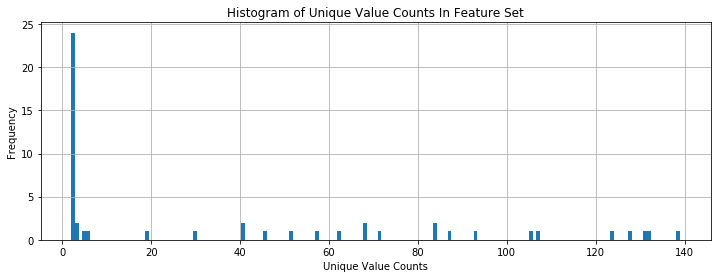

In [9]:
#Plot a histogram of these unique variable counts. 
ax = unique_count.hist(bins=num_instances,figsize=(12,4))
ax.set_xlabel("Unique Value Counts")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of Unique Value Counts In Feature Set")

* We observe that nearly half the features are binary, and there are some features that appear to be discrete interger values, and a number of real-valued features. 

***
### Assess Missingness in Data

In [10]:
#Evaluate missingness and data availability
print("Missing Value Counts")
missing_count = td.isnull().sum()
missing_count

Missing Value Counts


Gender                               0
Symptoms                            18
Alcohol                              0
Hepatitis B Surface Antigen         17
Hepatitis B e Antigen               39
Hepatitis B Core Antibody           24
Hepatitis C Virus Antibody           9
Cirrhosis                            0
Endemic Countries                   39
Smoking                             41
Diabetes                             3
Obesity                             10
Hemochromatosis                     23
Arterial Hypertension                3
Chronic Renal Insufficiency          2
Human Immunodeficiency Virus        14
Nonalcoholic Steatohepatitis        22
Esophageal Varices                  52
Splenomegaly                        15
Portal Hypertension                 11
Portal Vein Thrombosis               3
Liver Metastasis                     4
Radiological Hallmark                2
Age at diagnosis                     0
Grams of Alcohol per day            48
Packs of cigarets per yea

* We confirm here that there is no missing data in the class/outcome variable. If there had been we would have to remove any rows with missing outcome later in the cleaning section. This is because we are performing supervised learning, i.e.  (label/outcome) required for modeling. 

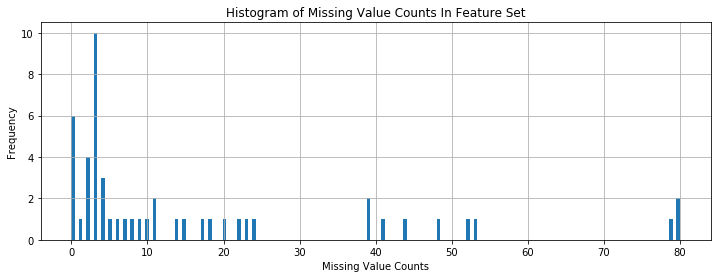

In [11]:
#Plot a histogram of the missingness observed over all features in the dataset
ax = missing_count.hist(bins=num_instances,figsize=(12,4))
ax.set_xlabel("Missing Value Counts")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of Missing Value Counts In Feature Set")

***
# PREPROCESSING
Every unique dataset and analysis comes with it's own characteristics and challenges.  Therefore preprocessing requires an understanding of the target data and analysis goal and may require fewer, additional, or alternative steps than what we describe here. Also note that an exploratory analysis and data cleaning go hand in hand and are often completed together. 

***
## Data Cleaning

### Remove Rows
Given that our task is to train a predictive classification model (i.e. supervised learning), remove any rows that have a missing outcome variable value. 
* In this analysis all rows have values so this can be skipped.

### Remove Columns
Remove unneeded or clearly irrelevant columns such as instance id. Also remove any columns that might contribute to [data leakage](https://machinelearningmastery.com/data-leakage-machine-learning/). E.g. When applying supervised learning to train a predictive model, remove any features that would not be available when it comes time to apply the model to data outside of the training data. 
* We have reviewed the data dictionary for our target dataset and have found no columns that need to be removed for this analysis. This will be skipped. 

### Deal with Missing Data
The first challenge in dealing with missing data is to understand the nature of the [missingness](https://en.wikipedia.org/wiki/Missing_data). Values in a data set can be (1) missing completely at random (MCAR), (2) missing at random (MAR), or missing not at random (MNAR). 

Many downstream machine learning algorithms and respective implementations are not designed to accomodate the presence of missing value in a dataset (e.g. the popular Python ML package, [scikit-learn](https://scikit-learn.org/stable/), does not allow missing values). Generally there are four main approaches to handle missing data: (1) imputaton - values are added in the place of missing data using one of many proposed strategies, (2) omission - instances and/or features with missing data values are discarded from further analysis, (3) in cases where missingness is not or may not be MCAR, a new varibable can be constructed (i.e. feature construction) that describes if a value was missing or not (i.e. asks the question, is missingness itself informative?), and (4) analysis - by directly applying downstream methods that are unaffected by missing values. 

* For the purposes of this analysis we will assume that the missing data is MCAR.  Since we will be using skikit-learn to complete our downstream modeling, we can not leave missing values in the dataset. Furthermore, because there is not a particularly large number of instances or features in our data we will avoid ommitting either. Therefore in this analysis we have opted to impute the missing values with a common simple approach, i.e. we will apply **'median-value imputation'** to real-valued features, and **'mode-value imputation'** to discrete features.

Note that any employed imputation method is essentially making an 'educated guess' that may be introducing bias.  I recommend that analysis be completed directly using methods that treat missing data 'neutrally' or ignore it, whenever possible. 


In [12]:
# Median-Value Imputation
for c in td.columns:
    td[c].fillna(td[c].median(), inplace=True)

In [13]:
#Re-evaluate missingness and data availability
print("Missing Value Counts")
missing_count = td.isnull().sum()
missing_count

Missing Value Counts


Gender                              0
Symptoms                            0
Alcohol                             0
Hepatitis B Surface Antigen         0
Hepatitis B e Antigen               0
Hepatitis B Core Antibody           0
Hepatitis C Virus Antibody          0
Cirrhosis                           0
Endemic Countries                   0
Smoking                             0
Diabetes                            0
Obesity                             0
Hemochromatosis                     0
Arterial Hypertension               0
Chronic Renal Insufficiency         0
Human Immunodeficiency Virus        0
Nonalcoholic Steatohepatitis        0
Esophageal Varices                  0
Splenomegaly                        0
Portal Hypertension                 0
Portal Vein Thrombosis              0
Liver Metastasis                    0
Radiological Hallmark               0
Age at diagnosis                    0
Grams of Alcohol per day            0
Packs of cigarets per year          0
Performance 

### Cast Variable Types (as needed)
We examine how the variable types are being automatically detected by the Pandas package to either confirm that they are correct or to 'cast' variables so that Pandas and any other applied algorithms will know how to handle each variable when necessary. 

In [14]:
td.dtypes

Gender                                int64
Symptoms                            float64
Alcohol                               int64
Hepatitis B Surface Antigen         float64
Hepatitis B e Antigen               float64
Hepatitis B Core Antibody           float64
Hepatitis C Virus Antibody          float64
Cirrhosis                             int64
Endemic Countries                   float64
Smoking                             float64
Diabetes                            float64
Obesity                             float64
Hemochromatosis                     float64
Arterial Hypertension               float64
Chronic Renal Insufficiency         float64
Human Immunodeficiency Virus        float64
Nonalcoholic Steatohepatitis        float64
Esophageal Varices                  float64
Splenomegaly                        float64
Portal Hypertension                 float64
Portal Vein Thrombosis              float64
Liver Metastasis                    float64
Radiological Hallmark           

* Based on the data dictionary a number of variables have been assigned the wrong data type by Pandas.  We will remedy this below. 

* Before moving forward we will first recode our class variable follow the more conventional data standard of the 'positive' class being the minority class.  This will help with downstream evaluation interpretation. We are effectively rephrasing the predictive goal for this data to 'predicting the target event of a patient dying' which represents the miniority class. From her on out, class 0 = survived 1 year while class 1 = died. 


In [15]:
#Recode class values (0's to 1's and 1's to 0's) 
td[outcome_name]=td[outcome_name].replace(to_replace=0, value=2)
td[outcome_name]=td[outcome_name].replace(to_replace=1, value=0)
td[outcome_name]=td[outcome_name].replace(to_replace=2, value=1) 

#Grab column names as a list
header = list(td)

#Cast variable types as needed. It is useful here to specifiy categorical variables here as 'object' for the exploratory analysis.
td[header[0:23]] = td[header[0:23]].astype(dtype='object')
td[['Age at diagnosis']] = td[['Age at diagnosis']].astype(dtype='float64')
td[['Performance Status*']] = td[['Performance Status*']].astype(dtype='float64')
td[['Class Attribute']] = td[['Class Attribute']].astype(dtype='object')

#Confirm correct casting of variable types. 
td.dtypes

Gender                               object
Symptoms                             object
Alcohol                              object
Hepatitis B Surface Antigen          object
Hepatitis B e Antigen                object
Hepatitis B Core Antibody            object
Hepatitis C Virus Antibody           object
Cirrhosis                            object
Endemic Countries                    object
Smoking                              object
Diabetes                             object
Obesity                              object
Hemochromatosis                      object
Arterial Hypertension                object
Chronic Renal Insufficiency          object
Human Immunodeficiency Virus         object
Nonalcoholic Steatohepatitis         object
Esophageal Varices                   object
Splenomegaly                         object
Portal Hypertension                  object
Portal Vein Thrombosis               object
Liver Metastasis                     object
Radiological Hallmark           

***
## Exploratory/Descriptive Analysis
In this section of the notebook we continue our exploratory analysis of the dataset to guide downstream processing and analysis. Here we focus on the following: 

* Basic summary statistics (real-valued features)
* Identify class imbalance
* Examing univariate relationships between each feature and outcome with appropriate visualizations
    * IF outcome = categorical/discrete and feature = categorical/discrete, THEN use contingency table count bar plot
    * IF outcome = categorical/discrete and feature = real/continuous, THEN use boxplot
    * IF outcome = real/continuous and feature = real/continuous, THEN use scatterplot
    * IF outcome = real/continuous and feature = categorical/discrete, THEN use boxplot
* Univariate analysis, i.e. between each feature and outcome (using appropriate test) - We have picked appropriate non-parametric tests here.
    * IF outcome = categorical/discrete and feature = categorical/discrete, THEN use Chi Square Test
    * IF outcome = categorical/discrete and feature = real/continuous, THEN use Mann-Whitney Test
    * IF outcome = real/continuous and feature = real/continuous, THEN use Spearman Correlation
    * IF outcome = real/continuous and feature = categorical/discrete, THEN use Mann-Whitney Test
* Look for outliers
* Other exploratory visualizations might be useful depending on the target problem/data. 

### Basic Summary Statistics
Applied to any real-valued features in the dataset.
Examine the min and max values in the summary below to identify any obvious (impossible) outliers. 

In [16]:
td.describe()

,Age at diagnosis,Grams of Alcohol per day,Packs of cigarets per year,Performance Status*,Encephalopathy degree*,Ascites degree*,International Normalised Ratio*,Alpha-Fetoprotein (ng/mL),Haemoglobin (g/dL),Mean Corpuscular Volume,...,Gamma glutamyl transferase (U/L),Alkaline phosphatase (U/L),Total Proteins (g/dL),Creatinine (mg/dL),Number of Nodules,Major dimension of nodule (cm),Direct Bilirubin (mg/dL),Iron,Oxygen Saturation (%),Ferritin (ng/mL)
count,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,1.650000e+02,165.000000,165.000000,...,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000
mean,64.690909,72.169697,13.890909,1.018182,1.157576,1.436364,1.418897,1.836580e+04,12.882121,95.116667,...,266.416970,211.298667,8.833636,1.115333,2.727273,6.626788,1.602000,84.354545,32.166424,369.180606
std,13.319534,64.176930,43.491732,1.181528,0.427008,0.683346,0.472327,1.454756e+05,2.125649,8.328639,...,256.647138,166.536394,11.338656,0.936911,1.788730,4.812579,3.642705,40.120263,21.350400,335.015936
min,20.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.840000,1.200000e+00,5.000000,69.500000,...,23.000000,1.280000,3.900000,0.200000,0.000000,1.500000,0.100000,0.000000,0.000000,0.000000
25%,57.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.180000,5.200000e+00,11.500000,90.000000,...,92.000000,109.000000,6.400000,0.710000,1.000000,3.000000,0.500000,78.000000,27.000000,283.000000
50%,66.000000,75.000000,0.000000,1.000000,1.000000,1.000000,1.300000,3.300000e+01,13.050000,94.950000,...,179.500000,162.000000,7.050000,0.850000,2.000000,5.000000,0.700000,83.000000,27.000000,295.000000
75%,74.000000,100.000000,15.000000,2.000000,1.000000,2.000000,1.530000,4.790000e+02,14.600000,100.300000,...,343.000000,260.000000,7.500000,1.100000,5.000000,8.500000,1.100000,85.000000,29.500000,297.000000
max,93.000000,500.000000,510.000000,4.000000,3.000000,3.000000,4.820000,1.810346e+06,18.700000,119.600000,...,1575.000000,980.000000,102.000000,7.600000,5.000000,22.000000,29.300000,224.000000,126.000000,2230.000000


### Class Imbalance
Determine what magnitude (if any) of [class imbalance](http://www.chioka.in/class-imbalance-problem/) exists in this dataset. Classes are considered to be 'balanced' if there are an equal number of instances within each class.  Class imbalance can be accounted for by applying the proper evaluation metrics downstream.  Generally speaking machine learning methods are most successful when training on more 'balanced' datasets.  Datasets can be artificially proprocessed to be more balanced using [oversampling and undersampling](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis) methods.  

Counts of each class


0    102
1     63
Name: Class Attribute, dtype: int64

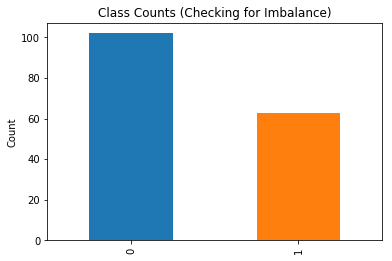

In [17]:
print("Counts of each class")
td[outcome_name].value_counts()
td[outcome_name].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.title('Class Counts (Checking for Imbalance)')

* We observe some class imbalance (1:1.61) where there are more 1's than 0's, where 1=lived, and 0=died.

In [18]:
#Code to automatically select and generate the most appropriate exploratory data visualization pairing each indepentend variable (i.e. feature) with the dependent variable (i.e. outcome) 
def graph_test_selector(feature_name, outcome_name, data, p_val_dict):

    if data[feature_name].dtype == 'object' and data[outcome_name].dtype == 'object': #Feature and Outcome are discrete/categorical/binary
        #Generate contingency table count bar plot. ------------------------------------------------------------------------
        #Calculate Contingency Table - Counts
        print('#################')
        table = pd.crosstab(data[feature_name], data[outcome_name])
        print(table)
        geom_bar_data = pd.DataFrame(table)
        mygraph = geom_bar_data.plot(kind='bar')
        plt.ylabel('Count')
        new_feature_name = feature_name.replace(" ","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("*","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("/","") #Deal with the dataset specific characters causing problems in this dataset.
        plt.savefig('Exploratory_Plots/BarPlot_'+str(new_feature_name)+'_'+outcome_name+'.pdf')
        
        #Univariate association test (Chi Square Test of Independence - Non-parametric)
        c, p, dof, expected = scs.chi2_contingency(table)
        print("Chi Square P-value = "+str(p))
        
        #Identify and save features with 'significant' univariate association
        if p <= 0.05:
            p_val_dict[feature_name] = p
        
        
    elif data[feature_name].dtype == 'float64' and data[outcome_name].dtype == 'object': #Feature is continuous and Outcome is discrete/categorical/binary
        #Generate boxplot-----------------------------------------------------------------------------------------------------
        print('#################')
        print(feature_name)
        mygraph = data.boxplot(column=feature_name,by=outcome_name)
        plt.ylabel(feature_name)
        plt.title('')
        new_feature_name = feature_name.replace(" ","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("*","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("/","") #Deal with the dataset specific characters causing problems in this dataset.
        plt.savefig('Exploratory_Plots/BoxPlot_'+str(new_feature_name)+'_'+outcome_name+'.pdf')
        
        #Univariate association test (Mann-Whitney Test - Non-parametric)
        c, p = scs.mannwhitneyu(x=data[feature_name].loc[data[outcome_name] == 0],y=data[feature_name].loc[data[outcome_name] == 1])
        print("Mann-Whitney P-value = "+str(p))
        print("Mann-Whitney U-Statistic = "+str(c))

        #Identify and save features with 'significant' univariate association
        if p <= 0.05:
            p_val_dict[feature_name] = p
        
    elif data[feature_name].dtype == 'float64' and data[outcome_name].dtype == 'float64': #Feature is continuous and Outcome is discrete/categorical/binary
        #Generate scatterplot-------------------------------------------------------------------------------------------------
        print('#################')
        print(feature_name)
        mygraph = data.plot(x=feature_name,y=outcome_name,kind='scatter')
        new_feature_name = feature_name.replace(" ","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("*","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("/","") #Deal with the dataset specific characters causing problems in this dataset.
        plt.savefig('Exploratory_Plots/ScatterPlot_'+str(new_feature_name)+'_'+outcome_name+'.pdf')

        #Univariate association test (Spearman Rank-Order Correlation - Non-parametric)
        p = scs.spearmanr(x=data[feature_name],y=data[outcome_name])
        print("Spearman Correlation P-value = " + str(p))

        #Identify and save features with 'significant' univariate association
        if p <= 0.05:
            p_val_dict[feature_name] = p        

    elif data[feature_name].dtype == 'object' and data[outcome_name].dtype == 'float64': #Feature is continuous and Outcome is discrete/categorical/binary
        #Generate boxplot------------------------------------------------------------------------------------------------------
        print('#################')
        print(feature_name)
        mygraph = data.boxplot(column=outcome_name,by=feature_name)
        plt.ylabel(outcome_name)
        plt.title('')
        new_feature_name = feature_name.replace(" ","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("*","") #Deal with the dataset specific characters causing problems in this dataset.
        new_feature_name = new_feature_name.replace("/","") #Deal with the dataset specific characters causing problems in this dataset.
        plt.savefig('Exploratory_Plots/BoxPlot_'+str(new_feature_name)+'_'+outcome_name+'.pdf')
        
        #Univariate association test (Mann-Whitney Test - Non-parametric)
        c, p = scs.mannwhitneyu(x=data[outcome_name].loc[data[feature_name] == '0'],y=data[outcome_name].loc[data[feature_name] == '1'])
        print("Mann-Whitney P-value = "+str(p))
        print("Mann-Whitney U-Statistic = "+str(c))

        #Identify and save features with 'significant' univariate association
        if p <= 0.05:
            p_val_dict[feature_name] = p
            
    else:
        print("Variable type combination not found! Check that all variables have been properly cast as either 'object' or 'float64'!")
    

#################
Class Attribute   0   1
Gender                 
0                21  11
1                81  52
Chi Square P-value = 0.7710020346519707
#################
Class Attribute   0   1
Symptoms               
0.0              41  12
1.0              61  51
Chi Square P-value = 0.00793357794444806
#################
Class Attribute   0   1
Alcohol                
0                28  15
1                74  48
Chi Square P-value = 0.7374939625243255
#################
Class Attribute               0   1
Hepatitis B Surface Antigen        
0.0                          91  58
1.0                          11   5
Chi Square P-value = 0.7415316357198269
#################
Class Attribute          0   1
Hepatitis B e Antigen         
0.0                    102  62
1.0                      0   1
Chi Square P-value = 0.8072332250767934
#################
Class Attribute             0   1
Hepatitis B Core Antibody        
0.0                        76  51
1.0                        26  12

C:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Chi Square P-value = 0.002624463646548994
#################
Class Attribute         0   1
Radiological Hallmark        
0.0                    31  21
1.0                    71  42
Chi Square P-value = 0.8238248266245827
#################
Age at diagnosis
Mann-Whitney P-value = 0.01784161875604351
Mann-Whitney U-Statistic = 2586.5
#################
Grams of Alcohol per day
Mann-Whitney P-value = 0.23671375941502026
Mann-Whitney U-Statistic = 3005.5
#################
Packs of cigarets per year
Mann-Whitney P-value = 0.09664049604880104
Mann-Whitney U-Statistic = 2895.0
#################
Performance Status*
Mann-Whitney P-value = 9.393521645117886e-07
Mann-Whitney U-Statistic = 1886.0
#################
Encephalopathy degree*
Mann-Whitney P-value = 0.08974787002652518
Mann-Whitney U-Statistic = 2976.5
#################
Ascites degree*
Mann-Whitney P-value = 0.0003951810056896238
Mann-Whitney U-Statistic = 2385.0
#################
International Normalised Ratio*
Mann-Whitney P-value = 0.015

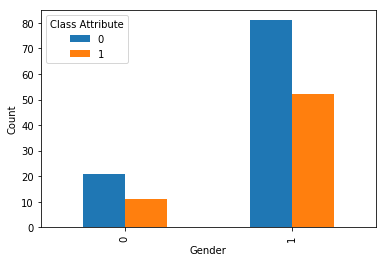

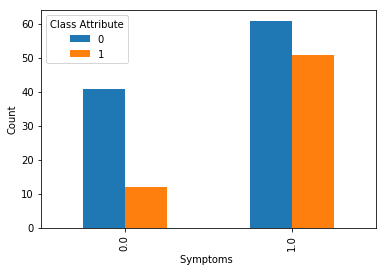

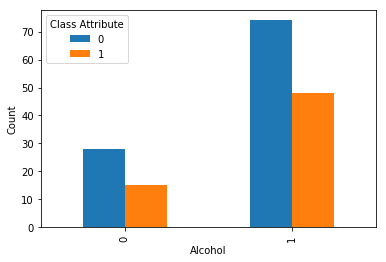

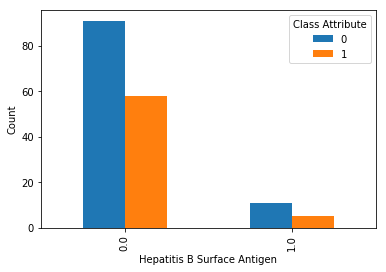

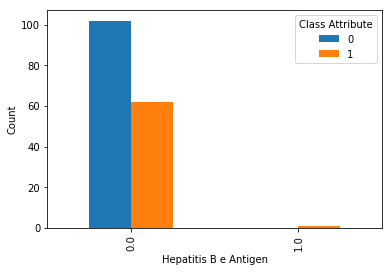

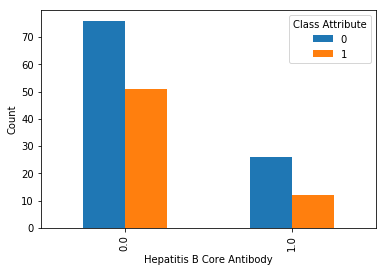

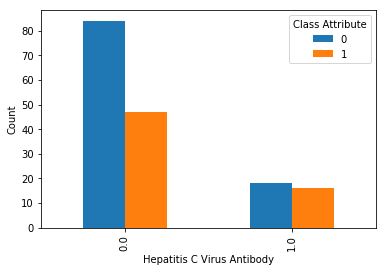

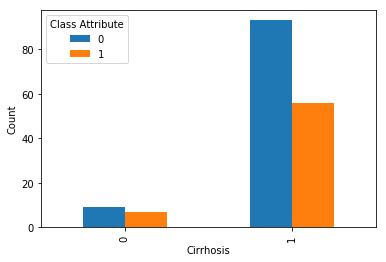

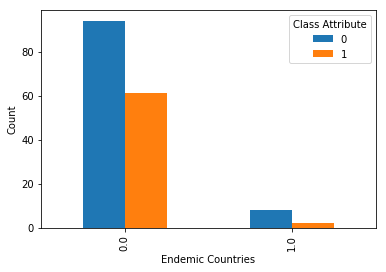

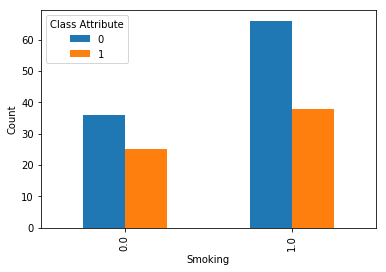

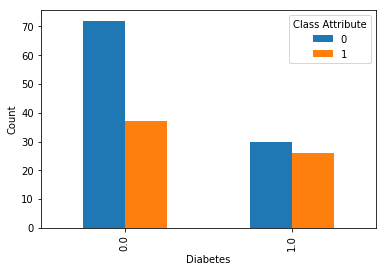

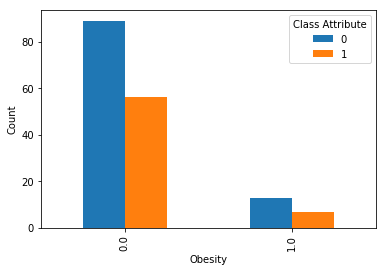

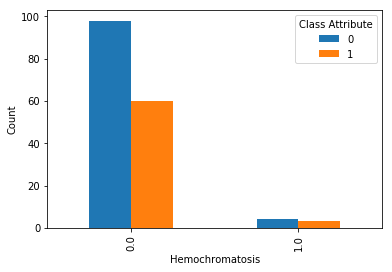

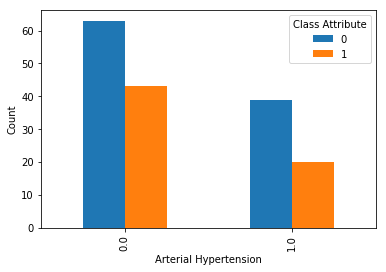

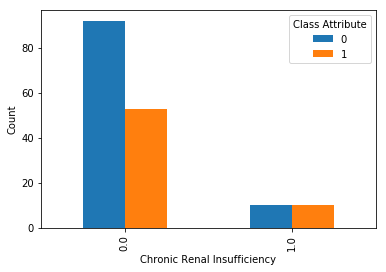

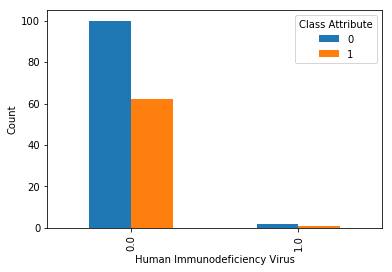

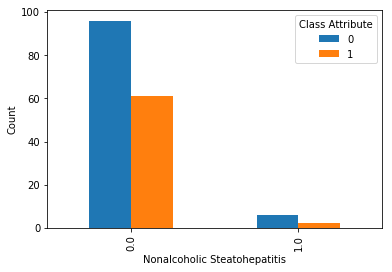

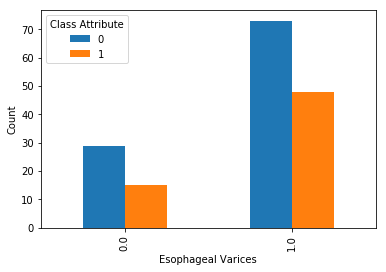

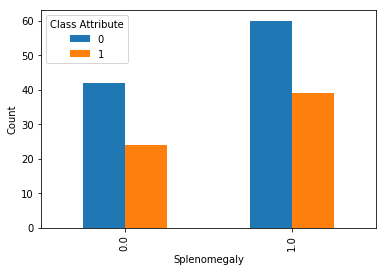

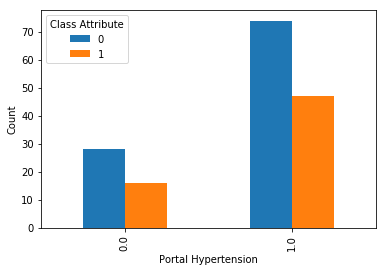

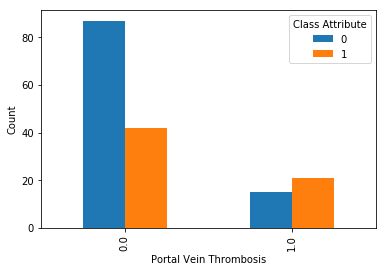

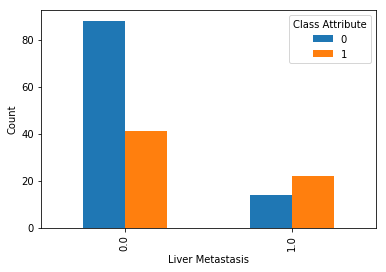

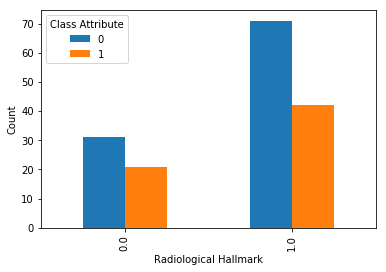

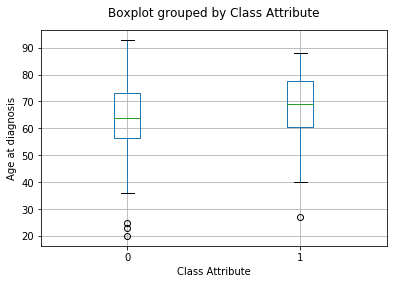

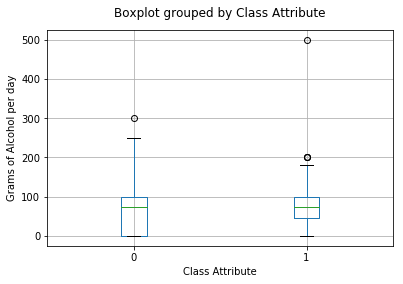

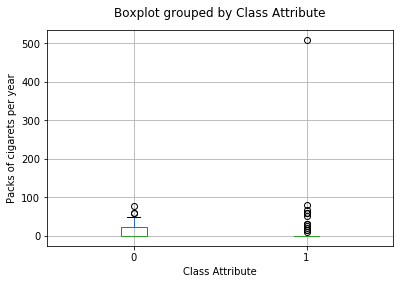

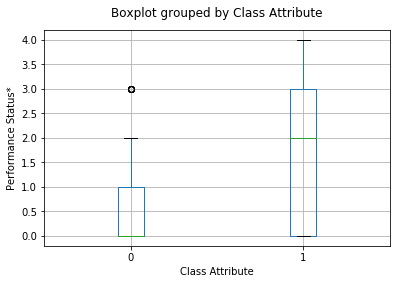

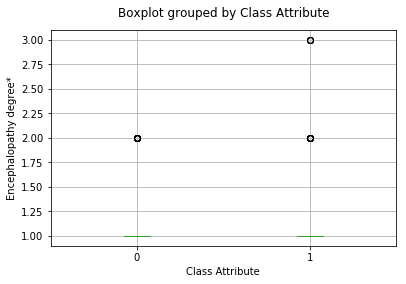

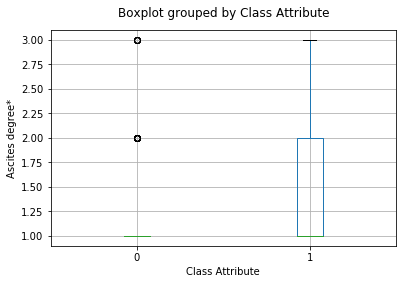

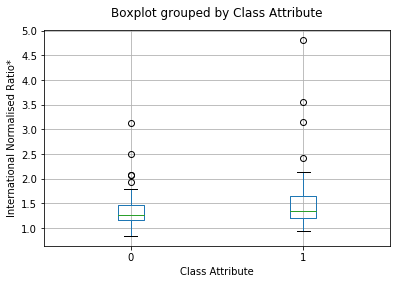

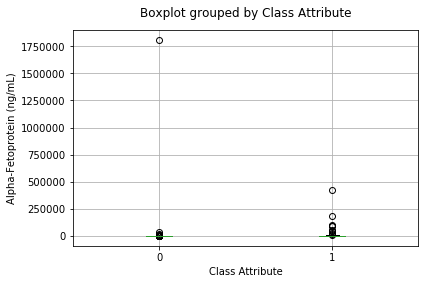

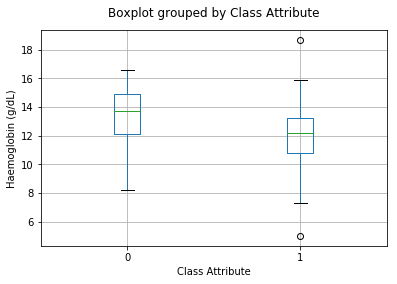

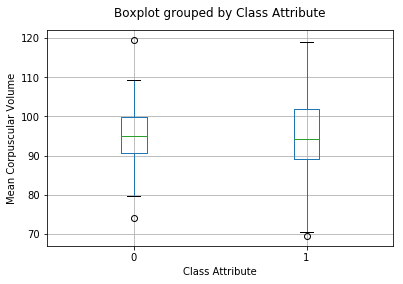

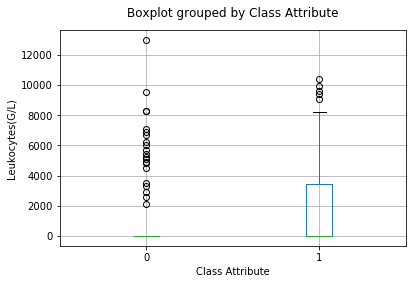

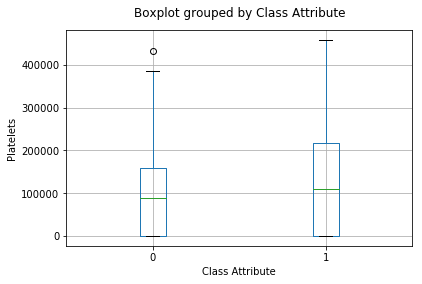

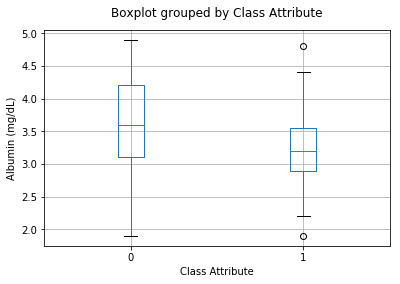

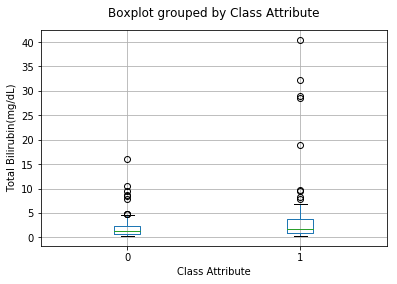

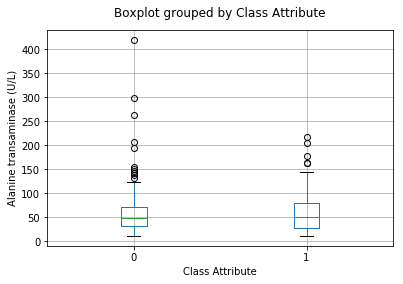

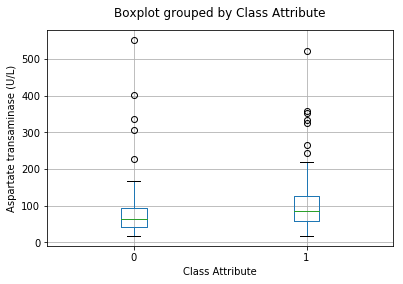

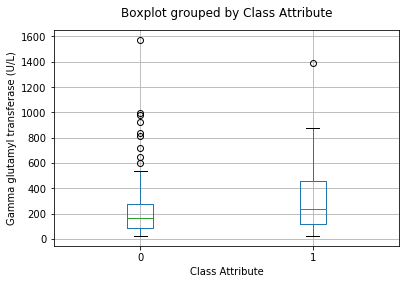

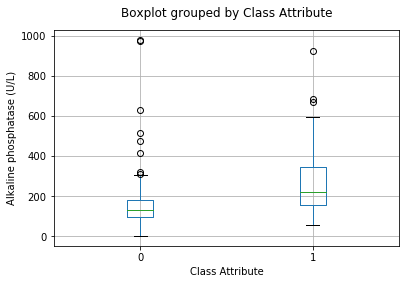

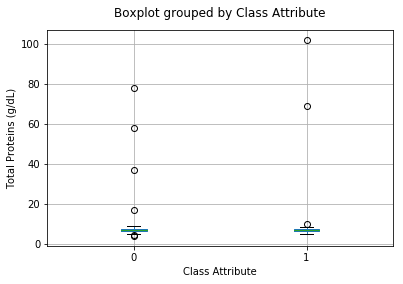

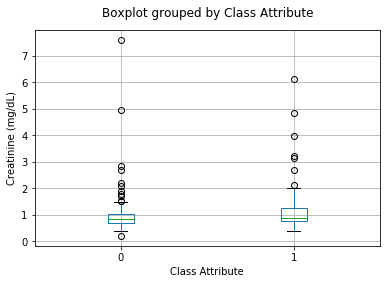

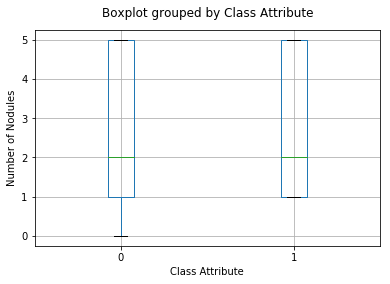

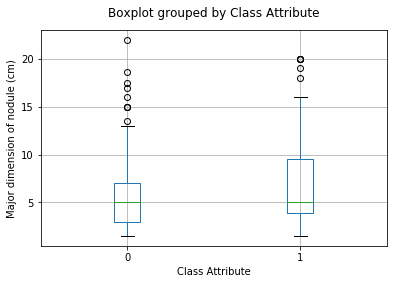

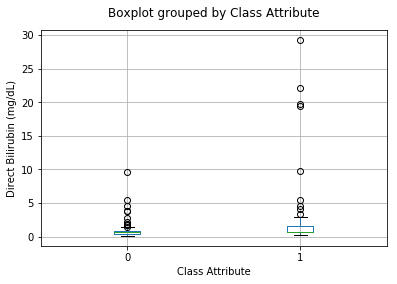

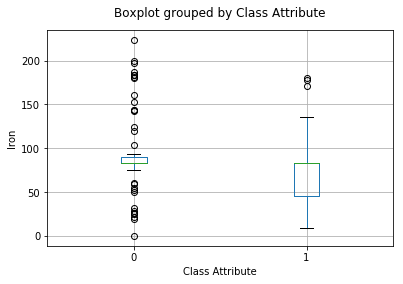

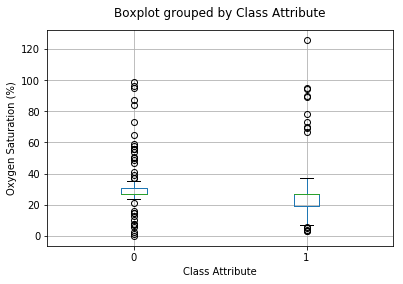

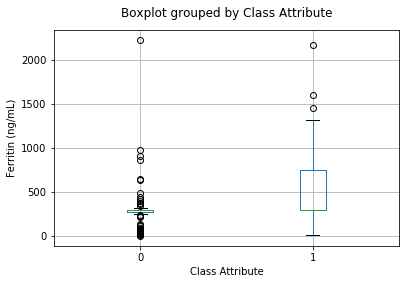

In [19]:
#Creates or ensures existance of folder to store exporatory plots. 
if not os.path.exists('Exploratory_Plots'):
    os.makedirs('Exploratory_Plots')

#Run appropriate univariate association analysis and generate an appropriate descriptive plot for each independent variable in the dataset. 
p_val_dict = {}

for each in td:
    if each != outcome_name: # Generate a plot for all independent variables. 
        graph_test_selector(each, outcome_name, td, p_val_dict)
print('###################################################')
print('Significant Univariate Associations:')
for each in p_val_dict:
    print(str(each)+": (p-val = "+str(p_val_dict[each])+")")
        

### Outliers
Our knowledge of the dataset and it's target domain should be applied to perform a manual quality control check of the data.  Specifically do we observe any [outliers](https://en.wikipedia.org/wiki/Outlier) in any of the variables of the dataset? For instance we might check the 'Age at Diagnosis' variable and confirm that we don't see any ages outside of what would be reasonable for this target study (e.g. it's highly unlikely to observe anyone over the age of 110). Obvious highly unlikely or impossible outliers should be removed (i.e. either treated as a missing value, or the entire instance removed). These are often typos during data entry. 

* We don't observe any obvious 'impossible' outliers that need to be removed, however some statistical outliers are observed in the boxplots and in the basic descriptive summary statistics above.  For the purposes of this analysis we will not remove any of these outliers, however this is a consideration for followup analysis. 

***
## Data Partitioning
In order to rigourously evaluate our downstream predictive modeling it is important to partition our entire datasets (at minimum) into a training as well as a testing dataset. Even better if you have a sufficient number of instances in your dataset, it may be split into [training, validation, and testing sets](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7). Testing data will not be applied until modeling is complete in order to evaluate our model on data it has not yet seen.  This is critical to properly evaluating predictive success. 

A more rigorous approach is to perform [k-fold cross validation](https://machinelearningmastery.com/k-fold-cross-validation/), where analyses are performed on resampled partitions of the data, such that all instances serve as part of the testing set in at least one of the partitions.  This stragegy helps to avoid the potential bias introduced by evaluating a model on one random training/testing partition. 

For the purposes of notebook simplicity we will employ a single basic training/testing partition of the dataset. 

* There are many ways to go about partitioning and different implementations of this in Python. Some built in cross validation methods exist in scikit-learn but they do not easily allow you to save your respective training and testing datasets as files for external replication. 
* Often it may be easier to perform certain feature processing steps (e.g. feature transformation, feature engineering, and feature construction) prior to completing data partitioning. For the purposes of this notebook it is convenient to introduce and perform data partitioning here under 'Preprocessing'. 

In [20]:
#For the purposes of downstream ML recast all features previously assigned to be 'object' to 'int'
td[header[0:23]] = td[header[0:23]].astype(dtype='int')
td[['Class Attribute']] = td[['Class Attribute']].astype(dtype='int')
td.dtypes
#Partition data into a training and testing set using convenient scikit-learn command.
train, test = train_test_split(td, test_size=0.2, stratify=td[outcome_name]) # 20% test set size, stratify option used to ensure class ratio is maintained in the partitions, random seed specified for reproducibility
train.shape # Confirm dimensions of training set
test.shape #Confirm dimensions of testing set

Gender                                int32
Symptoms                              int32
Alcohol                               int32
Hepatitis B Surface Antigen           int32
Hepatitis B e Antigen                 int32
Hepatitis B Core Antibody             int32
Hepatitis C Virus Antibody            int32
Cirrhosis                             int32
Endemic Countries                     int32
Smoking                               int32
Diabetes                              int32
Obesity                               int32
Hemochromatosis                       int32
Arterial Hypertension                 int32
Chronic Renal Insufficiency           int32
Human Immunodeficiency Virus          int32
Nonalcoholic Steatohepatitis          int32
Esophageal Varices                    int32
Splenomegaly                          int32
Portal Hypertension                   int32
Portal Vein Thrombosis                int32
Liver Metastasis                      int32
Radiological Hallmark           

(132, 50)

(33, 50)

* We confirm below that both the training and test sets have preserved the original class balance to help avoid this additional bias. 

Counts of each class in training data


0    82
1    50
Name: Class Attribute, dtype: int64

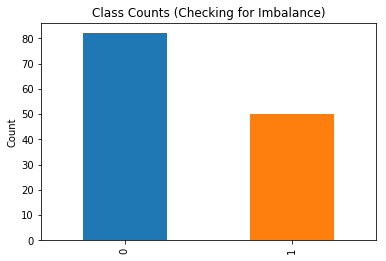

In [21]:
print("Counts of each class in training data")
train[outcome_name].value_counts()
train[outcome_name].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.title('Class Counts (Checking for Imbalance)')

Counts of each class in testing data


0    20
1    13
Name: Class Attribute, dtype: int64

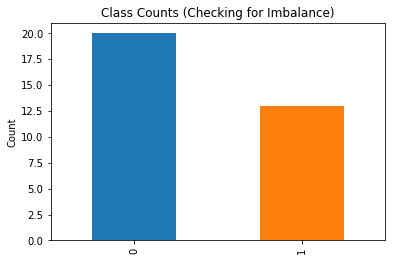

In [22]:
print("Counts of each class in testing data")
test[outcome_name].value_counts()
test[outcome_name].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.title('Class Counts (Checking for Imbalance)')

***
# FEATURE PROCESSING
Feature processing is all about improving the representation of data so that downstream machine learning can achieve higher performance. Feature processing can include any of the following: 

* [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering) - New features are custom-built from existing features using domain knowledge. The goal is to provide downstream algorithms features that are more accessible for a machine to train on. (E.g. taking start and stop dates, that an algorithm would struggle to make sense of, and engineer a feature that captures the time duration between these dates. Feature engineering is typically completed manually using domain expertise. 
* [Feature Transformation](https://www.quora.com/What-is-a-feature-transformation-in-machine-learning) - Application of 'algorithms' to create new features from existing ones. 
    * [Scaling](https://en.wikipedia.org/wiki/Scaling_(geometry) - Mathematically [normalizing](https://en.wikipedia.org/wiki/Normalization_(statistics) features to fall within a given range or [transformed](https://en.wikipedia.org/wiki/Data_transformation_(statistics) by a given function (e.g. log transformation).  Scaling can be an important preprocessing step for interpreting the output of statistical modeling analysis (e.g. linear regression). Typically scaling is less important for machine learning (there are exceptions). 
    * [Binning](https://en.wikipedia.org/wiki/Data_binning) - converting continuous/real valued features to discrete or categorical features.
    * [Dimensionality Reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction) - Also known as feature extraction or feature projection. Applies an algorithm designed to reduce the number of random variables under consideration by obtaining a set of principal variables, typically via some projection strategy (e.g. [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)).
    * [Feature Construction](https://www.semanticscholar.org/paper/Feature-Construction-Methods-%3A-A-Survey-Sondhi/1faf80be961715c763bfab82d577e2a86ae65a9a) - Can be viewed as a more 'automated' approach to feature engineering, where a computational methods combines 2 or more existing features, or even the output of some other machine learning model to 'construct' a new feature.
* [Feature Selection](https://en.wikipedia.org/wiki/Feature_selection) - The process of identifying a subset of 'relevant' and sometimes 'non-redundant' features to pass on to modeling.  Ideally feature selection will preserve all relevant features and eliminate all irrelevant or completely redundant features (however this is non-trivial). Three families of feature selection algorithms are typically described: filter-based methods, wrapper methods, and embedded methods. Notably, filter-based feature selection algorithms also serve as feature-weighting algorithms that can be employed as part of the exploratory analysis to assess which features are most likely to be informative. 
    * When applying filter-based feature selection it is generally up to the data scientist to decide how many variables to select, and how many to remove.  In datasets with very large numbers of features, it is usually a practical necessity to reduce the feature space as much as possible.  Different feature selection methods may offer some guidelines for when there is no evidence that a given feature is relevant (and thus may be removed from consideration). However, one must be aware of the inherant limitations of a given feature selection method before deciding whether to remove a feature, based on the goals or scope of the desired analysis (e.g. just because a feature selection method that can detect univariate associations suggests that a feature is irrelvant may not mean that a method that can take complex associations into account may identify it as being relevant). 

These components of an analysis pipeline are typically very problem/domain dependant, but are also tied to the modeling methods that plan to be utilized downstream (i.e. machine learning or traditional statistical modeling). In this notebook we will just demonstrate feature selection, as our dataset is relatively small (only 49 features), and our features do not require any obvious feature engineering or tranformation. 

* In particular, here we will try applying two different approaches: (1) [Mutual information](https://en.wikipedia.org/wiki/Mutual_information) an information theorgy approach for identifying features with a univariate association with outcome, (2) [ReliefF](https://en.wikipedia.org/wiki/Relief_(feature_selection) a filter-based feature selection algorithm that is uniquely able to indentify features with univariate associations as well as complex multivariate interactions that are predictive of outcome. 

***
### Feature Scoring/Selection - Mutual Information
Mutual information (MI) is a measure of the amount of information that one random variable has about another variable. 
MI between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean a strong dependency/association. 
Mutual Information "is not concerned" with whether the univariate association is linear or not.

array([0.        , 0.        , 0.        , 0.0463638 , 0.        ,
       0.00761724, 0.00218278, 0.        , 0.        , 0.04718344,
       0.05173367, 0.0103221 , 0.02680831, 0.05668522, 0.0269097 ,
       0.09796729, 0.02459128, 0.01482917, 0.        , 0.02500917,
       0.01216813, 0.0353921 , 0.01214552, 0.        , 0.        ,
       0.0654523 , 0.10510149, 0.10138181, 0.10737693, 0.        ,
       0.09294642, 0.04727048, 0.09749291, 0.        , 0.00623205,
       0.02562725, 0.01966669, 0.06609488, 0.01869973, 0.        ,
       0.07863423, 0.        , 0.        , 0.        , 0.01671023,
       0.03686733, 0.13549913, 0.10739583, 0.09363389])

,Names,Scores
0,Gender,0.000000
43,Number of Nodules,0.000000
42,Creatinine (mg/dL),0.000000
41,Total Proteins (g/dL),0.000000
39,Gamma glutamyl transferase (U/L),0.000000
33,Leukocytes(G/L),0.000000
29,International Normalised Ratio*,0.000000
23,Age at diagnosis,0.000000
18,Splenomegaly,0.000000
24,Grams of Alcohol per day,0.000000


([<matplotlib.axis.YTick at 0x20bcfafa630>,
 <a list of 49 Text yticklabel objects>)

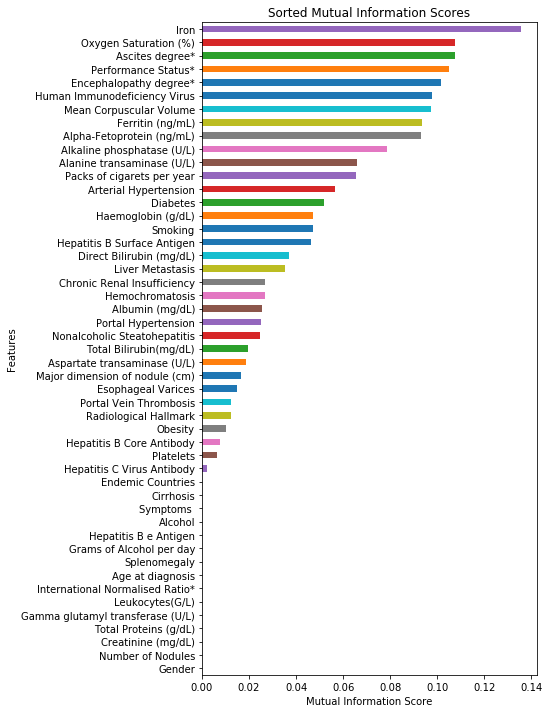

In [23]:
from sklearn.feature_selection import mutual_info_classif # Mutual information for a discrete target.
import seaborn as sns

#Split dataframe into features and outcome (standard format for scikit-learn methods)
x_train = train.drop(outcome_name, axis=1).values
y_train = train[outcome_name].values

#Later when evaluating models we will need y_test so we will create it now...
y_test = test[outcome_name].values

#Run mutual information algorithm
mi_results = mutual_info_classif(x_train, y_train)
mi_results

#Present results
header = train.columns.tolist()
features = header[0:len(header)-1]
names_scores = {'Names':features, 'Scores':mi_results} 
ns = pd.DataFrame(names_scores)
ns = ns.sort_values(by='Scores')
ns #Report sorted feature scores

#Visualize sorted feature scores
ns['Scores'].plot(kind='barh',figsize=(6,12))
plt.ylabel('Features')
plt.xlabel('Mutual Information Score')
plt.yticks(np.arange(len(features)), ns['Names'])
plt.title('Sorted Mutual Information Scores')
  

#### Feature Selection (Mutual Information)
Any feature with a mutual information score at or close to zero is unlikely to have a univariate association with outcome. Therefore these features might be considered for removal.  Here we simply select all features with a mutual information score higher than zero. 

In [24]:
selected_MI = []
i=0
for each in ns['Scores']:
    if float(each) > 0.0:
        #print(each)
        selected_MI.append(ns['Names'][i])
    i+=1 
len(selected_MI)
print(selected_MI)

34

['Human Immunodeficiency Virus', 'Nonalcoholic Steatohepatitis', 'Esophageal Varices', 'Splenomegaly', 'Portal Hypertension', 'Portal Vein Thrombosis', 'Liver Metastasis', 'Radiological Hallmark', 'Age at diagnosis', 'Grams of Alcohol per day', 'Packs of cigarets per year', 'Performance Status*', 'Encephalopathy degree*', 'Ascites degree*', 'International Normalised Ratio*', 'Alpha-Fetoprotein (ng/mL)', 'Haemoglobin (g/dL)', 'Mean Corpuscular Volume', 'Leukocytes(G/L)', 'Platelets', 'Albumin (mg/dL)', 'Total Bilirubin(mg/dL)', 'Alanine transaminase (U/L)', 'Aspartate transaminase (U/L)', 'Gamma glutamyl transferase (U/L)', 'Alkaline phosphatase (U/L)', 'Total Proteins (g/dL)', 'Creatinine (mg/dL)', 'Number of Nodules', 'Major dimension of nodule (cm)', 'Direct Bilirubin (mg/dL)', 'Iron', 'Oxygen Saturation (%)', 'Ferritin (ng/mL)']


***
### Feature Scoring/Selection - ReliefF
ReliefF is a filter-based feature weighting and selection algorithm that utilizes a nearest neighbor component to scoring that allows it to indirectly estimate feature weights based not only univariate associations but also interacting multivariate associations. We employ a recently developed scikit-learn package called [scikit-rebate](https://github.com/EpistasisLab/scikit-rebate) which includes access to many Relief-based algorithms including the best known 'ReliefF'.

,Names,Scores
37,Alanine transaminase (U/L),-0.008890
8,Endemic Countries,-0.007561
16,Nonalcoholic Steatohepatitis,-0.006031
12,Hemochromatosis,-0.005669
11,Obesity,-0.005174
5,Hepatitis B Core Antibody,-0.004013
3,Hepatitis B Surface Antigen,-0.003659
17,Esophageal Varices,-0.002476
22,Radiological Hallmark,-0.000702
18,Splenomegaly,-0.000680


([<matplotlib.axis.YTick at 0x20bcfd82278>,
 <a list of 49 Text yticklabel objects>)

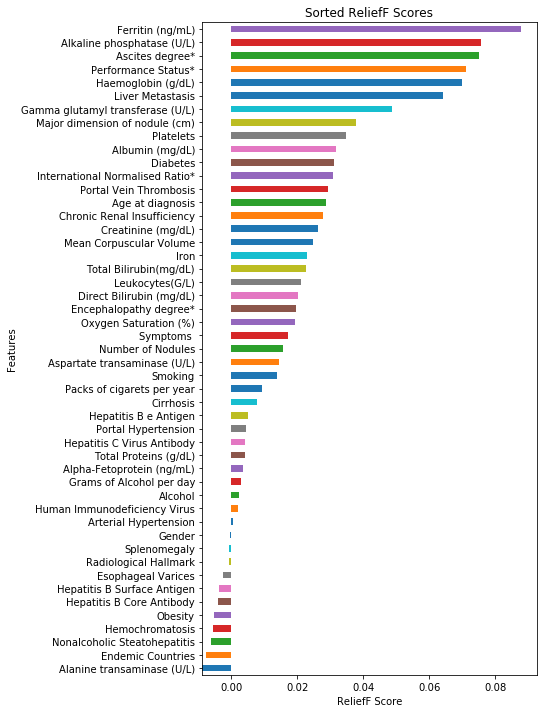

In [25]:
from skrebate import ReliefF

x_train = x_train.astype('float') #ReBATE cannot handle variables of type 'object' so we temporarily convert all features to type 'float'
reliefF_results = ReliefF().fit(x_train, y_train) #ReliefF as a default 'k' hyperparameter that is set to 100 by default (i.e. 100 nearest neighbors)

#Present results
header = train.columns.tolist()
features = header[0:len(header)-1]
names_scores = {'Names':features, 'Scores':reliefF_results.feature_importances_} 
ns = pd.DataFrame(names_scores)
ns = ns.sort_values(by='Scores')
ns #Report sorted feature scores

#Visualize sorted feature scores
ns['Scores'].plot(kind='barh',figsize=(6,12))
plt.ylabel('Features')
plt.xlabel('ReliefF Score')
plt.yticks(np.arange(len(features)), ns['Names'])
plt.title('Sorted ReliefF Scores')

#### Feature Selection (ReliefF)
Any ReliefF score at or below zero is unlikely to have an association with outcome. Therefore these features might be considered for removal.  Here we simply select all features with a ReliefF score higher than zero. 

In [26]:
selected_ReliefF = []
i=0
for each in ns['Scores']:
    if float(each) > 0.0:
        #print(each)
        selected_ReliefF.append(ns['Names'][i])
    i+=1 
len(selected_ReliefF)
print(selected_ReliefF)

38

['Obesity', 'Hemochromatosis', 'Arterial Hypertension', 'Chronic Renal Insufficiency', 'Human Immunodeficiency Virus', 'Nonalcoholic Steatohepatitis', 'Esophageal Varices', 'Splenomegaly', 'Portal Hypertension', 'Portal Vein Thrombosis', 'Liver Metastasis', 'Radiological Hallmark', 'Age at diagnosis', 'Grams of Alcohol per day', 'Packs of cigarets per year', 'Performance Status*', 'Encephalopathy degree*', 'Ascites degree*', 'International Normalised Ratio*', 'Alpha-Fetoprotein (ng/mL)', 'Haemoglobin (g/dL)', 'Mean Corpuscular Volume', 'Leukocytes(G/L)', 'Platelets', 'Albumin (mg/dL)', 'Total Bilirubin(mg/dL)', 'Alanine transaminase (U/L)', 'Aspartate transaminase (U/L)', 'Gamma glutamyl transferase (U/L)', 'Alkaline phosphatase (U/L)', 'Total Proteins (g/dL)', 'Creatinine (mg/dL)', 'Number of Nodules', 'Major dimension of nodule (cm)', 'Direct Bilirubin (mg/dL)', 'Iron', 'Oxygen Saturation (%)', 'Ferritin (ng/mL)']


* Our selection criteria for features in this notebook will be defined by the union of features identified as potentially relevant by either of our feature selection methods. This unique union of terms is determined and the respective training and testing data subsets are created.

In [27]:
selected_feature_names = list(set(selected_MI).union(selected_ReliefF))
len(selected_feature_names)
selected_feature_names

38

['International Normalised Ratio*',
 'Packs of cigarets per year',
 'Aspartate transaminase (U/L)',
 'Esophageal Varices',
 'Direct Bilirubin (mg/dL)',
 'Gamma glutamyl transferase (U/L)',
 'Iron',
 'Encephalopathy degree*',
 'Alanine transaminase (U/L)',
 'Splenomegaly',
 'Albumin (mg/dL)',
 'Number of Nodules',
 'Nonalcoholic Steatohepatitis',
 'Ferritin (ng/mL)',
 'Major dimension of nodule (cm)',
 'Performance Status*',
 'Human Immunodeficiency Virus',
 'Ascites degree*',
 'Oxygen Saturation (%)',
 'Total Proteins (g/dL)',
 'Obesity',
 'Mean Corpuscular Volume',
 'Grams of Alcohol per day',
 'Portal Hypertension',
 'Hemochromatosis',
 'Creatinine (mg/dL)',
 'Chronic Renal Insufficiency',
 'Age at diagnosis',
 'Portal Vein Thrombosis',
 'Alkaline phosphatase (U/L)',
 'Platelets',
 'Radiological Hallmark',
 'Alpha-Fetoprotein (ng/mL)',
 'Total Bilirubin(mg/dL)',
 'Haemoglobin (g/dL)',
 'Arterial Hypertension',
 'Liver Metastasis',
 'Leukocytes(G/L)']

* Notably all of the features selected by Mutual Information were also selected by ReliefF, along with some others for a total of 39 out of the original 49 features. 

* It is often good practice to run ML modeling on both the orignial set of all features as well as the subset of selected features to confirm that performance was not negatively impacted by the feature selection choices. We will skip this for simplicity here. 

#### Create new training dataframes (filtered by feature selection)

In [28]:
#Filter training data (these now only include features, not outcome)
x_train_fs = train[selected_feature_names]
x_train_fs.shape
#Filter testing data (these now only include features, not outcome)
x_test_fs = test[selected_feature_names]
x_test_fs.shape

(132, 38)

(33, 38)

# MODELING
This is the stage that everyone thinks of when it comes to machine learning and data mining. 

## Method Selection
As a general rule of thumb it is typically best practice to run a number of machine learning algorithm in modeling (i.e. at least 2-3), and ideally those methods should have differen strengths and weaknesses.  This is due to the [no-free-lunch theorem](https://en.wikipedia.org/wiki/No_free_lunch_theorem) that essentially suggests that no one method can perform ideally in all circumstances.  Therefore, when we are faced with the analysis of some new dataset there is no way to know the optimal strategy to apply ahead of time. Sometimes simple analysis methods can work optimally (as well as run quickly with interpretable results), however other times much more complicated methods are required that may have different trade-offs. 

In this analysis/notebook we have decided to focus on two machine learning modeling approaches: (1) [decision trees](https://en.wikipedia.org/wiki/Decision_tree), and (2) [random forests](https://en.wikipedia.org/wiki/Random_forest). We have selected decision trees because the are an easier to understand and intuitive ML modeling approach.  Further the models produced by these systems are easy to interpret and apply. However decision trees are often suseptible to bias, and even minor instance sampling differences in the training set can alter the trained model impacting model generalizability and reproducibility. As a secondary method we focus on random forests, which are essentially a methodological extension of the decision tree concept. Random forests are one of the best known and most widely applied ML algorithms.  They introduce the concept of an ensemble, training a large group of trees to collectively constitute a predition model.  This allows these methods to be more robust to bias, obtain better generalization capability, and are still easily and quickly trained. However, random forests are inherently more difficult to interpret than a decision tree, and (like decision trees) struggle to model complex interactions in data particularly when the number of features gets to be large. 

* Below we start off by training both ML modeling algorithms on our target training data and report the standard training accuracy of each. 

### Decision Tree Modeling
Like with most any ML algorithm you may have heard of, it isn't really a single specific method but a family of method variants.  The scikit-learn package implements a decision tree algorithm that is an 

In [29]:
from sklearn import tree #import decision tree package
from sklearn import metrics #import evaluation metric package

#Set a random seed for the notebook so that individual runs of the notebook yield the same results
np.random.seed(5)

# Train a decision tree model. (no hyperparameters set other than random seed, i.e. default hyperparameters applied)
dt = tree.DecisionTreeClassifier()
dt = dt.fit(x_train_fs, y_train)

# Determine model's predictions on training data
train_pred = dt.predict(x_train_fs)
print("Training Accuracy:",metrics.accuracy_score(y_train, train_pred))

# Determine model's predictions on testing data
test_pred = dt.predict(x_test_fs)
print("Testing Accuracy:",metrics.accuracy_score(y_test, test_pred))

Training Accuracy: 1.0
Testing Accuracy: 0.6363636363636364


* Using a basic accuracy metric (i.e. (TP+TN)/(TP+TN+FP+FN)) our decision tree yields a training accuracy and a testing accuracy.  Keep in mind that our dataset is imbalanced so this evaluation metric is not optimal and our interpretation may be biased. We will revist this below. 

### Random Forest Modeling

In [30]:
from sklearn.ensemble import RandomForestClassifier #import decision tree package

# Train a random forest model. (no hyperparameters set other than random seed, i.e. default hyperparameters applied)

rf = RandomForestClassifier()
rf = rf.fit(x_train_fs, y_train)

# Determine model's predictions on training data
train_pred = rf.predict(x_train_fs)
print("Training Accuracy:",metrics.accuracy_score(y_train, train_pred))

# Determine model's predictions on testing data
test_pred = rf.predict(x_test_fs)
print("Testing Accuracy:",metrics.accuracy_score(y_test, test_pred))


Training Accuracy: 0.9924242424242424
Testing Accuracy: 0.7878787878787878


C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Hyperparameter Sweep
Most any ML method has 'hyper' or 'run' parameters that the user can tune/adjust, modifying how the algorithm functions. The process of tweaking and optimizing these parameters to improve ML performance is known as [hyperparameter optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization). A hyperparameter sweep mostly commonly includes idenifying which algorithm parameters are known to, or are likely to, impact performance on a given dataset, and then varying the setting of these one or more paramters in separate runs of the algorithm.  This step is not only important for squeezing the maximum performance out of ML methods, but also in fairly compairing the performance of different ML methods on given datasets.  

Out of necessity, almost all ML algorithms have default hyperparameters specified (related to [default arguments](https://en.wikipedia.org/wiki/Default_argument). First and foremost, default parameters are specified so that the algorithm is able to run even if the user forgets to specify these hyperparamters. They are often set with the intention of testing out the method on a 'toy' or demonstration dataset included with the software, or they are set as simple, accessible placeholders to ensure that the first time a user runs the software it runs smoothly and quickly. However default parameters are certainly not guarenteed (if even likely) to lead to optimal ML performance on a given dataset. 

The most common and basic hyperparameter sweep strategies include a [grid search](https://medium.com/datadriveninvestor/an-introduction-to-grid-search-ff57adcc0998) or a [random search](https://en.wikipedia.org/wiki/Random_search), but other more sophisticated searches are also employed. 

Like with many other things in ML, there is no absolute right way to perform a hyperparameter sweep. One could easily waste a large amount of computational time on an exhaustive serach of hyperparameter settings and combinations without improving performance much, or at all. However some degree of hyperparameter searching outside of using the default hyperparameter settings is considered essential to ML best practices. 

### Decision Tree - Random Sweep of Major Hyperparameters
Here we consider some of the hyperparameters with the most potential to impact decision tree performance. 

* max_depth = The maximum depth of the tree. (default = None)
* min_samples_split = The minimum number of samples required to split an internal node: (default = 2)
* min_samples_leaf  = The minimum number of samples required to be at a leaf node. (default = 1)
* criterion = The function to measure the quality of a split. (Default = 'gini')

We employ a simple randomized hyperparameter search (with built in, internal cross validation - based on our training sets)

In [31]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# prepare a range/set of hyperparameter values for each
param_grid = {"max_depth": [3, None], "min_samples_split": randint(2, 10), "min_samples_leaf": randint(1, 10), "criterion": ["gini", "entropy"]}

model = tree.DecisionTreeClassifier()
#Specifics of the random sweep - up to 100 randomly selected hyperparameter combinations
hp_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100)
hp_search.fit(x_train_fs, y_train)

# summarize the results of the random parameter search
print("**************************")
print(hp_search.best_score_)
print("************************************************************************************")
print("The model with the best accuracy was built with the following hyperparameter values.")
print(hp_search.best_params_)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          fit_params={}, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'criterion': ['gini', 'entropy'], 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020BC9726908>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020BC9445D30>, 'max_depth': [3, None]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

**************************
0.7196969696969697
************************************************************************************
The model with the best accuracy was built with the following hyperparameter values.
{'criterion': 'entropy', 'min_samples_leaf': 1, 'min_samples_split': 2, 'max_depth': 3}


* We retrain a decision tree on our training data using these 'optimal' parameters. 

In [32]:
# Train a new decision tree model. (hyperparameters set to those that yielded the best accuracy in the random sweep)
dt = tree.DecisionTreeClassifier(max_depth=hp_search.best_params_['max_depth'], min_samples_leaf=hp_search.best_params_['min_samples_leaf'], min_samples_split=hp_search.best_params_['min_samples_split'], criterion=hp_search.best_params_['criterion'])
dt = dt.fit(x_train_fs, y_train)

# Determine model's predictions on training data
dt_train_pred = dt.predict(x_train_fs)
print("Training Accuracy:",metrics.accuracy_score(y_train, dt_train_pred))

# Determine model's predictions on testing data
dt_test_pred = dt.predict(x_test_fs)
print("Testing Accuracy:",metrics.accuracy_score(y_test, dt_test_pred))

Training Accuracy: 0.8333333333333334
Testing Accuracy: 0.7272727272727273


### Random Forest - Random Sweep of Major Hyperparameters
Here we consider some of the hyperparameters with the most potential to impact random forest performance. 

* n_estimators = The number of trees in the forest. (default = 10)
* max_depth = The maximum depth of the tree. (default = None)
* min_samples_split = The minimum number of samples required to split an internal node: (default = 2)
* min_samples_leaf  = The minimum number of samples required to be at a leaf node. (default = 1)
* criterion = The function to measure the quality of a split. (Default = 'gini')

We employ a simple randomized hyperparameter search (with built in, internal cross validation - based on our training sets)

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# prepare a range/set of hyperparameter values for each
param_grid = {"n_estimators": randint(2, 1000),"max_depth": [3, None], "min_samples_split": randint(2, 10), "min_samples_leaf": randint(1, 10), "criterion": ["gini", "entropy"]}

model = RandomForestClassifier()
#Specifics of the random sweep - up to 100 randomly selected hyperparameter combinations
hp_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100)
hp_search.fit(x_train_fs, y_train)

# summarize the results of the random parameter search
print("**************************")
print(hp_search.best_score_)
print("************************************************************************************")
print("The model with the best accuracy was built with the following hyperparameter values.")
print(hp_search.best_params_)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020BCF3C9BE0>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020BCF3C9630>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000020BCF3C9DD8>, 'criterion': ['gini', 'entropy'], 'max_depth': [3, None]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, 

**************************
0.7348484848484849
************************************************************************************
The model with the best accuracy was built with the following hyperparameter values.
{'criterion': 'entropy', 'min_samples_leaf': 4, 'n_estimators': 6, 'min_samples_split': 4, 'max_depth': None}


* We retrain a random forest on our training data using these 'optimal' parameters. 

In [34]:
# Train a new random forest model. (hyperparameters set to those that yielded the best accuracy in the random sweep)
rf = RandomForestClassifier(n_estimators = hp_search.best_params_['n_estimators'], max_depth=hp_search.best_params_['max_depth'], min_samples_leaf=hp_search.best_params_['min_samples_leaf'], min_samples_split=hp_search.best_params_['min_samples_split'], criterion=hp_search.best_params_['criterion'])
rf = rf.fit(x_train_fs, y_train)

# Determine model's predictions on training data
rf_train_pred = rf.predict(x_train_fs)
print("Training Accuracy:",metrics.accuracy_score(y_train, rf_train_pred))

# Determine model's predictions on testing data
rf_test_pred = rf.predict(x_test_fs)
print("Testing Accuracy:",metrics.accuracy_score(y_test, rf_test_pred))

Training Accuracy: 0.8863636363636364
Testing Accuracy: 0.8484848484848485


## Model Evaluation
Now that we have trained models, how do we best evaluate and compare the performance of these models?  Proper evaluation is critical to making good conclusions. Many metrics and measures of model 'goodness' exist. Part of what differentiates these evaluation methods is understanding the assumptions being made by a given metric, or what the metric prioritizes as important for model goodness. A nice review of key evaluation metrics can be found [here](http://www.davidsbatista.net/blog/2018/08/19/NLP_Metrics/). 

Below we will apply some different evaluation methods to the decision tree model that was trained using the 'optimal' parameters settings indentified in the random sweeep (we will leave out the random forest evaluation here for brevity). All evaluations will focus on predictive performance on the testing data. 

The metrics are typically based on calculations using the different possible classification predictions that can be made: True Positives (TP), True Negative (TN), False Positive (FP), and False Negative (FN).  See [here](https://towardsdatascience.com/the-mystery-of-true-positive-true-negative-false-positive-and-false-negative-fd73c78c905a) to review TP, TN, FP, FN.

Let's start by calculating each of these for our test data using our 'optimized' decision tree model. Recall that our dataset is imbalanced and there are more 'negatives' than 'positives'. 

In [35]:
from sklearn.metrics import confusion_matrix

#Calculate confusion matrix (true outcomes, predicted outcomes)
TN, FP, FN, TP = confusion_matrix(y_test, dt_test_pred).ravel()

print("TP = "+str(TP))
print("FP = "+str(FP))
print("FN = "+str(FN))
print("TN = "+str(TN))

TP = 8
FP = 4
FN = 5
TN = 16


These values (TP,FP,FN,TN) are components used to calculate a number of different evaluation metrics for classification tasks:

* Accuracy = (TP+TN)/(TP+TN+FP+FN)
* Precision (a.k.a. Sensitivity)= TP/(TP+FP)
* Recall (a.k.a. True Positive Rate) = TP/(TP+FN)
* Specificity = TN/(TN+FP)
* False Positive Rate = FP/(FP+TN)

* F1 Score = 2*(Precision * Recall)/(Precision + Recall)
* Balanced Accuracy = (Sensitivity + Specificity)/2

We will calculate these for our 'optimized' decision tree model.  Be aware that a different set of evaluation metrics would be used for continuous-valued outcomes (i.e. regression tasks). 

In [36]:
# Determine model's predictions on testing data
print("All metrics report performance on testing data!")
print("***********************************************")
print("Accuracy:",metrics.accuracy_score(y_test, dt_test_pred))
print("***********************************************")

from sklearn.metrics import classification_report

#Generate a classification report
report = classification_report(y_test, dt_test_pred)
print (report)
print("***********************************************")
specificity = TN/(TN+FP)
sensitivity = TP/(TP+FP)
print("Specificity: "+str(specificity))
print("***********************************************")
print("False Positive Rate: "+str(FP/(TN+FP))+ "   Note: Lower is better.")
print("***********************************************")
print("Balanced Accuracy: "+str((sensitivity+specificity)/2))

All metrics report performance on testing data!
***********************************************
Accuracy: 0.7272727272727273
***********************************************
             precision    recall  f1-score   support

          0       0.76      0.80      0.78        20
          1       0.67      0.62      0.64        13

avg / total       0.72      0.73      0.73        33

***********************************************
Specificity: 0.8
***********************************************
False Positive Rate: 0.2   Note: Lower is better.
***********************************************
Balanced Accuracy: 0.7333333333333334


* For imbalanced datasets, balanced accuracy is less biased in comparing performance as it weights the accurate prediction of both classes equally. 

### ROC Curve and AUC metric
The ROC curve is a metric used for the evaluation of binary classification models, where we evaluate how the model would perform if different cuttoff thresholds (of predicted class probability) between the two classes were considered. This is useful when we don't necessarily know which class is more important to predict accurately. For example, if we wanted to evaluate how well a test for a highly infectious disease worked, we would care much more about identifying positive individuals correctly than negative individuals, even at the expense of additional false positives.

To calculate an ROC curve first we need to get the class prediction probabilites from the model, rather than just the predicted classes, since these predicted classes were decided based on a predetermined classification threshold. 

(0.0, 1.0)

(0.0, 1.05)

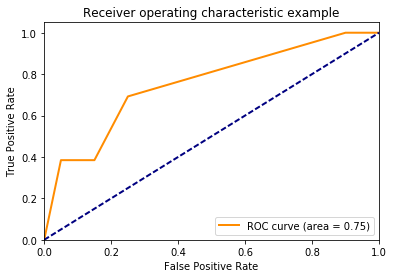

In [37]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

#Determine probabilities of class predictions for each test instance (this will be used much later in calculating an ROC curve)
probas_ = dt.fit(x_train_fs, y_train).predict_proba(x_test_fs)

# Compute ROC curve and area the curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, probas_[:, 1])
roc_auc = auc(fpr, tpr)

#Plot the ROC Curve and include AUC in figure. 
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Precision Recall Plot - An alternative to ROC when there is class imbalance
While we have successuflly generated an ROC curve above, when there is a moderate to large class imbalance it is considered better practice to evaluate models with a precision/recall plot (PRC) ([see here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/)).

AUC of PRC = 0.7110362755524047
Average Precision = 0.7110362755524047


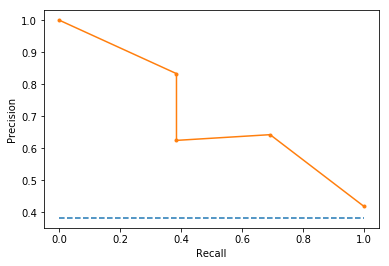

In [38]:
# Compute ROC curve and area the curve
precision, recall, thresholds = metrics.precision_recall_curve(y_test, probas_[:, 1])
roc_auc = auc(recall,precision)

# calculate average precision score
ap = metrics.average_precision_score(y_test, probas_[:, 1])

print("AUC of PRC = "+ str(roc_auc))
print("Average Precision = "+ str(ap))

from matplotlib import pyplot
# plot no skill - based on the imbalance ratio. Our ratio is 1:1.61 which translates to a no skill line of about .383
pyplot.plot([0, 1], [0.383, 0.383], linestyle='--')
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.')
pyplot.xlabel("Recall")
pyplot.ylabel("Precision")
# show the plot
pyplot.show()

# POSTPROCESSING
Here we discuss some of the last steps in the machine learning analysis pipeline geared towards understanding our model, drawing conclusions, deriving signifiance statistics on our results, or preparing our predictive model for deployment. Here we highlight some of the basics of interpreting our models.

## Interpretation
In some problem domains it may be sufficient to identify an accurate predictive model.  However in many other domains in order for anyone to have faith in the ability of the model to perform when applied to as yet unseen data, it's important to understand our model, including:
* What features are driving accurate predictions? (i.e. which features a truly relevant?)
* What is the nature of any multivariate associations (i.e. are there additive univariate effects, specific feature interactions, heterogeneous associations, or some combined complex relationship between relevant features and outcome?
* Can we understand the decision making process in making a prediction on a given instance? Does the model make sense based on our current understanding of the problem domain?
* Does the model lead us to any new understandings or insights about he problem domain?

### Visualize Decision Tree Model
Generate a visualization of the decision tree showing all nodes, splits, and leaves. 

'decisionTree.pdf'

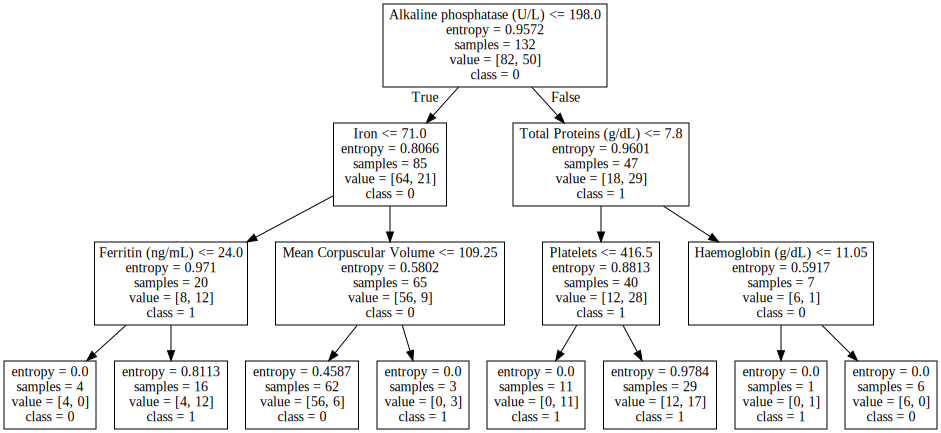

In [39]:
import graphviz 
dot_data = tree.export_graphviz(dt, out_file=None,feature_names=selected_feature_names, class_names=['0','1']) 
graph = graphviz.Source(dot_data) 
graph.render("decisionTree") 
graph

### Visualize Decision Tree Model - (the round about way)
To generate a visualization of the decision tree but are struggling with getting the graphviz python package to work, go through the following steps:
1) Run the next line of code below and a '.dot' file will be produced (you can open this with any text editor)

2) Copy the text in this file

3) Go to the following [weblink](http://webgraphviz.com/)

4) Paste the text in the Graphviz window.

5) Click 'generate graph'

6) Take screenshot of figure, paste in Powerpoint, crop, and save as picture. 


In [40]:
# Manually generate tree visualization
dotfile = open("dt.dot", 'w')
tree.export_graphviz(dt, out_file=dotfile, feature_names=selected_feature_names)
dotfile.close()

### Derive Rules from Decision Tree
We can also seek to extract human readible rule expressions from any branch paths from the root node (top) of the tree down to any given leaf node (bottom). 

In [41]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    #print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

tree_to_code(dt,selected_feature_names)

  if Alkaline phosphatase (U/L) <= 198.0:
    if Iron <= 71.0:
      if Ferritin (ng/mL) <= 24.0:
        return [[4. 0.]]
      else:  # if Ferritin (ng/mL) > 24.0
        return [[ 4. 12.]]
    else:  # if Iron > 71.0
      if Mean Corpuscular Volume <= 109.25:
        return [[56.  6.]]
      else:  # if Mean Corpuscular Volume > 109.25
        return [[0. 3.]]
  else:  # if Alkaline phosphatase (U/L) > 198.0
    if Total Proteins (g/dL) <= 7.800000190734863:
      if Platelets <= 416.5:
        return [[ 0. 11.]]
      else:  # if Platelets > 416.5
        return [[12. 17.]]
    else:  # if Total Proteins (g/dL) > 7.800000190734863
      if Haemoglobin (g/dL) <= 11.050000190734863:
        return [[0. 1.]]
      else:  # if Haemoglobin (g/dL) > 11.050000190734863
        return [[6. 0.]]


### Feature Importance Scores - Random Forest
Here we return to our random forest model to examine a commonly used output to help with model interpretation, i.e. feature importance scores. 

(38, 2)

,Names,Scores
24,Hemochromatosis,0.000000
19,Total Proteins (g/dL),0.000000
36,Liver Metastasis,0.000000
16,Human Immunodeficiency Virus,0.000000
23,Portal Hypertension,0.000000
12,Nonalcoholic Steatohepatitis,0.000000
26,Chronic Renal Insufficiency,0.000000
21,Mean Corpuscular Volume,0.000000
28,Portal Vein Thrombosis,0.000000
3,Esophageal Varices,0.000000


([<matplotlib.axis.YTick at 0x20bcf2ae8d0>,
 <a list of 38 Text yticklabel objects>)

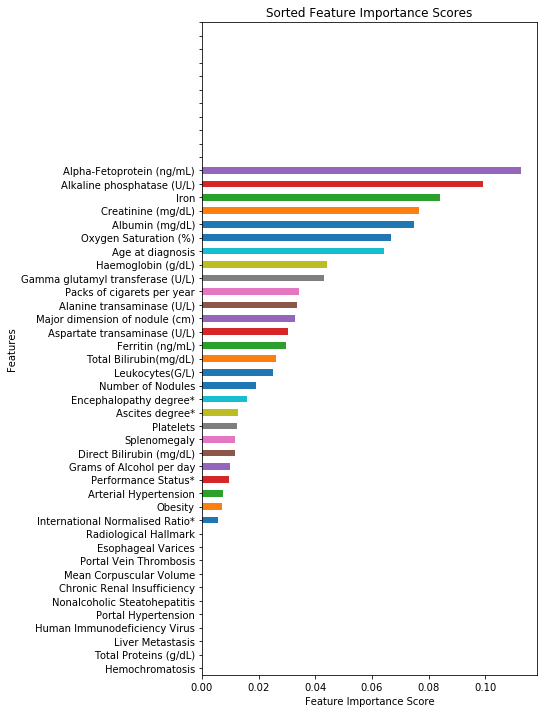

In [42]:
importances = rf.feature_importances_
names_importances = {'Names':selected_feature_names, 'Scores':importances} 
ni = pd.DataFrame(names_importances)
ni = ni.sort_values(by='Scores')
ni.shape
ni #Report sorted feature scores

#Visualize sorted feature scores
ni['Scores'].plot(kind='barh',figsize=(6,12))
plt.ylabel('Features')
plt.xlabel('Feature Importance Score')
plt.yticks(np.arange(len(features)), ni['Names'])
plt.title('Sorted Feature Importance Scores')

## Significance Analysis
When conducting a machine learning analysis on a stand-alone dataset, we may ask the question whether the model evaluation metrics we observed or feature selection weights, or the feature importance scores, etc are signifianctly higher than we might expect by chance within the given datasets.  This is where strategies like [permatuation testing](https://en.wikipedia.org/wiki/Resampling_(statistics)) can play a role in evaluating statistical significance of ML results. We won't complete permuation testing or additional significance anlaysis here.  

## Replication
The gold standard in any machine learnin analysis is to be able to replicate similar findings in a secondary dataset. For the dataset targeted in this notebook, no replication datasets are readily available so we will not conduct a replication analysis here. 

